In [1]:
import pandas as pd

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [5]:
iris_data = pd.read_csv("iris.data", delimiter=",")

In [7]:
type(iris_data)

pandas.core.frame.DataFrame

In [9]:
iris_data

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [11]:
iris_data.columns

Index(['sepal length', 'sepal width', 'petal length', 'petal width', 'class'], dtype='object')

In [13]:
X = iris_data[['sepal length', 'sepal width', 'petal length', 'petal width']]

In [15]:
X.shape

(150, 4)

In [17]:
y = iris_data['class']

In [19]:
y.shape

(150,)

In [21]:
class Node:
    def __init__(self, feature = None, value = None, threshold = None, left = None, right = None):
        self .feature = feature
        self.value = value
        self.threshold = threshold
        self.left = left
        self.right = right

In [23]:
class DecisionTree:
    def __init__(self, max_depth = None, min_samples_split = 2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
    
    def _entropy(self, data):
        counts = np.bincount(data)
        probabilities = counts / len(data)
        return -np.sum([p*np.log2(p) for p in probabilities if p > 0])

    def _information_gain(self, y, y_left, y_right):
        p = len(y_left) / len(y)
        return self._entropy(y) - p * self._entropy(y_left) - (1-p) * self._entropy(y_right)
        
    def _best_split(self, X, y):
        best_split = {}
        best_info_gain = -1
        _, n_cols = X.shape
        for feature_index in range(n_cols):
            feature_values = X[:,feature_index]
            thresholds = np.unique(feature_values)
            for threshold in thresholds:
                left_mask = feature_values <= threshold
                right_mask = feature_values > threshold
                y_left = y[left_mask]
                y_right = y[right_mask]
                if len(y_left) > 0 and len(y_right) > 0:
                    info_gain = self._information_gain(y,y_left,y_right)
                    if info_gain > best_info_gain:
                        best_split = {
                            'feature_index' : feature_index,
                            'threshold' : threshold,
                            'left_mask' : left_mask,
                            'right_mask' : right_mask,
                            'gain' : info_gain
                        }
                        best_info_gain = info_gain
            if best_split:
                print(f"Selected feature {best_split['feature_index']} with threshold {best_split['threshold']} as decision node")
            return best_split

    def _build_tree(self, X, y, depth = 0):
        n_rows,_ = X.shape
        best_split = self._best_split(X,y)
        if n_rows >= self.min_samples_split and depth <= self.max_depth :
            if best_split and best_split['gain'] > 0 :
                left = self._build_tree(X[best_split['left_mask']],y[best_split['left_mask']], depth + 1)

                right = self._build_tree(X[best_split['right_mask']],y[best_split['right_mask']], depth + 1)
                return Node(
                    feature = best_split['feature_index'],
                    threshold = best_split['threshold'],
                    left = left,
                    right = right
                )
        leaf_value = Counter(y).most_common(1)[0][0]
        return Node(value = leaf_value)

    def fit(self, X, y):
        self.root = self._build_tree(X,y)

    def _predict(self, x, tree):
        if tree.value is not None:
            return tree.value
        if x[tree.feature] == tree.threshold:
            return self._predict(x, tree.left)
        else:
            return self._predict(x, tree.right)

    def predict(self, X):
        return np.array([self._predict(x, self.root) for x in X])

    def predict(self, X):
        return np.array([self._predict(x, self.root) for x in X])

    def _plot_tree(self, node, depth=0, pos=(0.5, 1.0), parent_pos=None, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(25, 14))
            ax.set_axis_off()
        if node.value is not None:
            ax.text(pos[0], pos[1], f'Leaf: {node.value}', ha='center', va='center', bbox=dict(facecolor='lightgrey', edgecolor='black'))
        else:
            ax.text(pos[0], pos[1], f'X[{node.feature}] <= {node.threshold}', ha='center', va='center', bbox=dict(facecolor='lightblue', edgecolor='black'))
        if parent_pos:
            ax.plot([parent_pos[0], pos[0]], [parent_pos[1], pos[1]], 'k-')
        if node.left:
            self._plot_tree(node.left, depth + 1, (pos[0] - 0.5 / (2 ** depth), pos[1] - 0.1), pos, ax)
        if node.right:
            self._plot_tree(node.right, depth + 1, (pos[0] + 0.5 / (2 ** depth), pos[1] - 0.1), pos, ax)
        if ax is None:
            plt.show()
    
    def plot_tree(self):
        self._plot_tree(self.root)

In [25]:
def train_test_split(X, y, test_size = 0.2, random_state = 42):
    random_state = np.random.seed(random_state)
    shuffle = np.random.permutation(len(X))
    test_size = int(len(X) * test_size)
    test_shuffle = shuffle[:test_size]
    train_shuffle = shuffle[test_size:]
    return X[train_shuffle], X[test_shuffle], y[train_shuffle], y[test_shuffle]

In [27]:
def accuracy(y_true, ypred):
    return np.sum(y_true == y_pred) / len(y_true)

In [29]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris['data']
y = iris['target']

In [31]:
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
base_model = DecisionTree(max_depth = 5, min_samples_split = 2)
base_model.fit(X_train, y_train)

Selected feature 0 with threshold 5.4 as decision node
Selected feature 0 with threshold 4.8 as decision node
Selected feature 0 with threshold 4.3 as decision node
Selected feature 0 with threshold 4.9 as decision node
Selected feature 0 with threshold 5.0 as decision node
Selected feature 0 with threshold 5.1 as decision node
Selected feature 0 with threshold 5.2 as decision node
Selected feature 0 with threshold 5.3 as decision node
Selected feature 0 with threshold 6.1 as decision node
Selected feature 0 with threshold 5.5 as decision node
Selected feature 0 with threshold 5.8 as decision node
Selected feature 0 with threshold 5.7 as decision node
Selected feature 0 with threshold 5.6 as decision node
Selected feature 0 with threshold 6.0 as decision node
Selected feature 0 with threshold 5.9 as decision node
Selected feature 0 with threshold 7.0 as decision node
Selected feature 0 with threshold 6.9 as decision node
Selected feature 0 with threshold 6.5 as decision node
Selected f

In [35]:
y_pred = base_model.predict(X_test)

In [37]:
y_pred

array([1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2])

In [39]:
accu = accuracy(y_test, y_pred)

In [41]:
print(f'Model acuuracy is: {accu}')

Model acuuracy is: 0.4


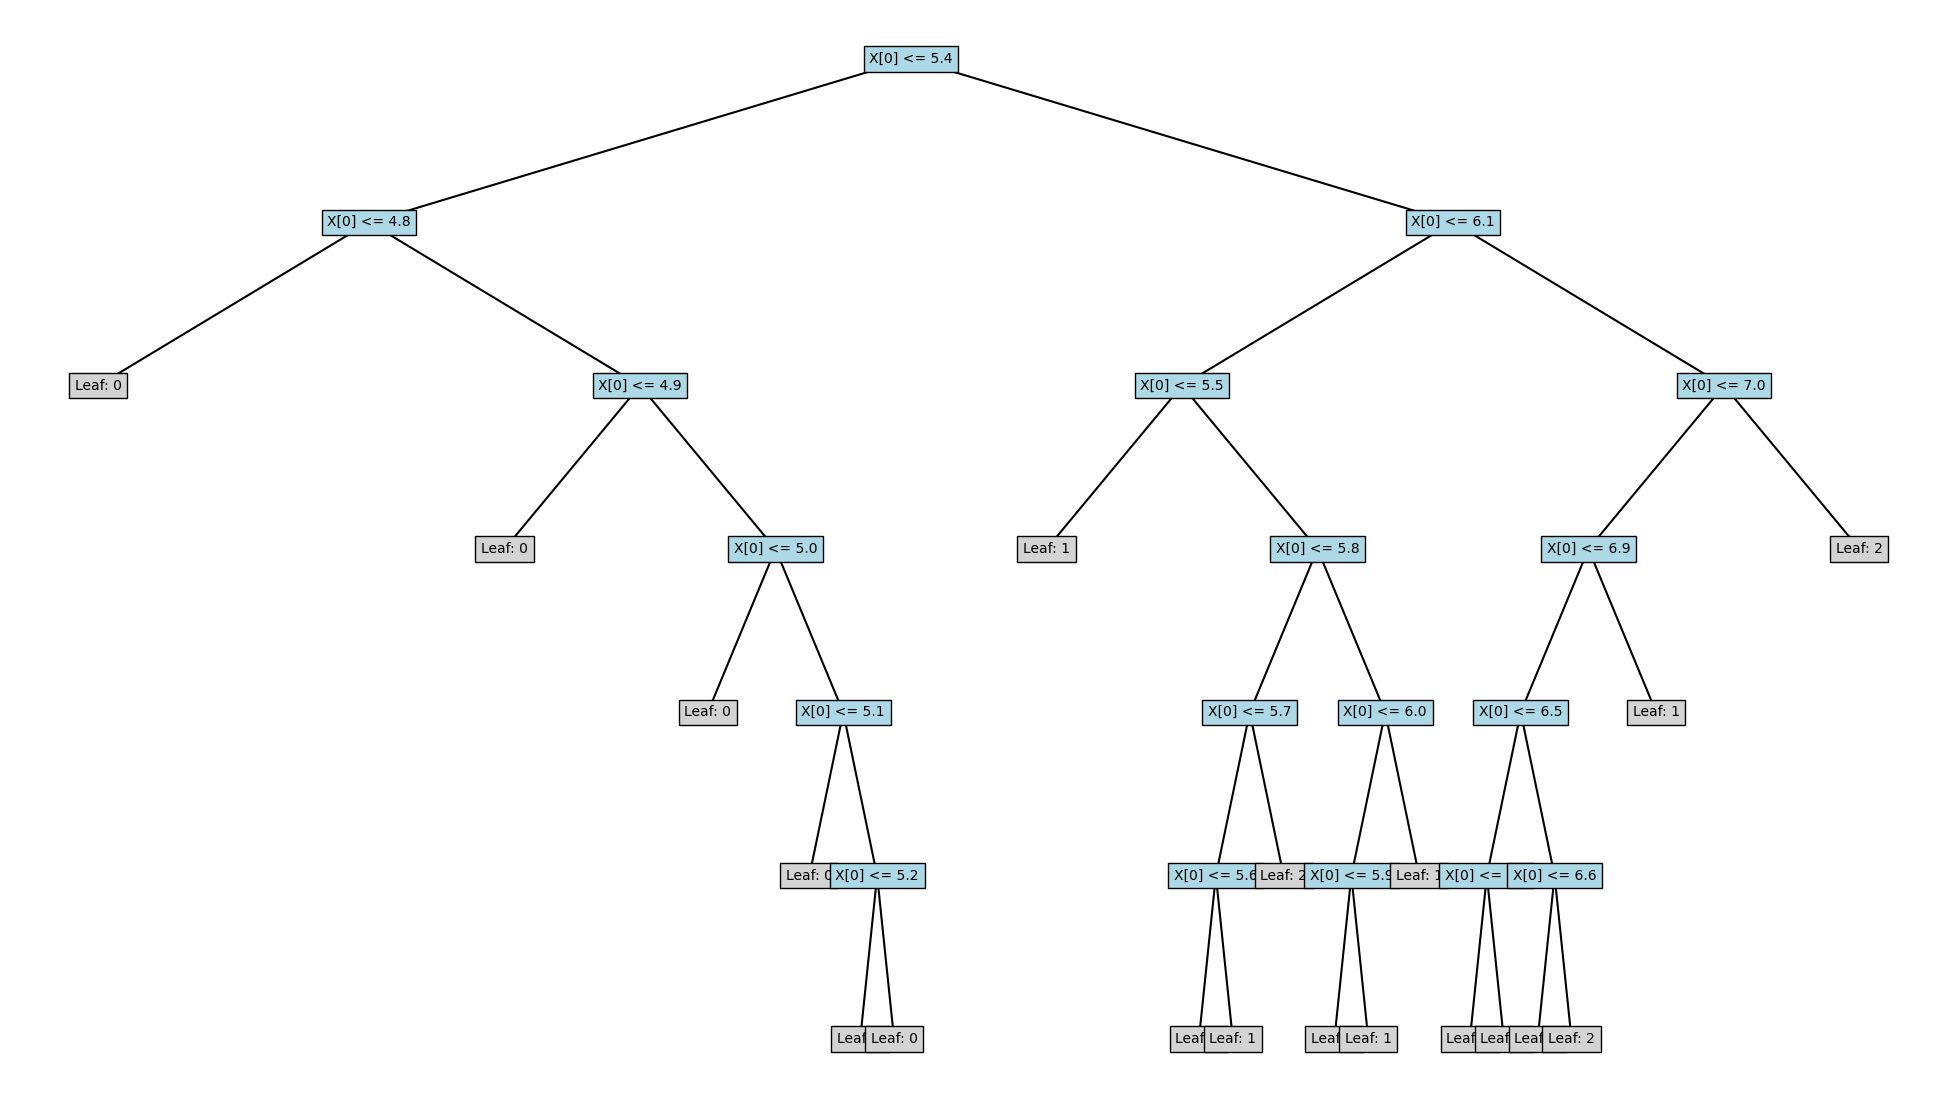

In [43]:
base_model.plot_tree()